### 1. Synthetic data warm-up; plotting decision regions/boundaries

The file `data/data/assignment1-classification.csv` contains a synthetic classification dataset with 400 2-dimensional observations.

- Make a scatter plot of the data using color to indicate class label.

- Use `GridSearchCV` with a `RepeatedKFold` cross-validation strategy and `accuracy` as the scoring metric to identify an optimal value of `n_neighbors` for a `KNeighborsClassifier` fit.

- Using the results of your search, plot average accuracy versus number of neighbors. Highlight the optimum on your plot.

- Plot the decision boundary of the model stored in the `best_estimator_` field of your search object over the scatter plot of the data and shade the decision regions in different colors. 

  By the way &mdash; this best estimator is, by default, refit on the whole training set. [See the docs for `GridSearchCV`](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html) for details.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import GridSearchCV,RepeatedKFold
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.decomposition import PCA,IncrementalPCA


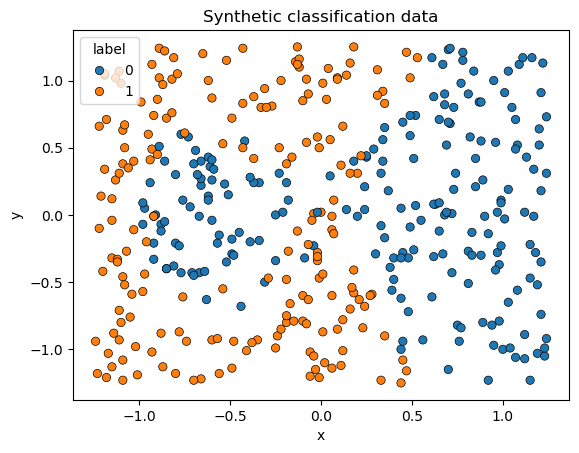

In [55]:
data=pd.read_csv('data/assignment1-classification.csv')

## scatter plot of data
sns.scatterplot(data=data,x='x', y='y' ,hue='label',edgecolor='black')
plt.title('Synthetic classification data')
plt.show()

{'n_neighbors': 11}


Text(0.5, 1.0, 'KNN accuracy for different values of K')

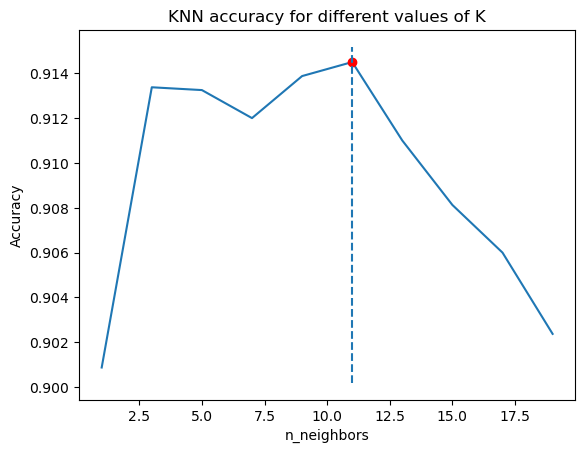

In [ ]:
## The Grid search for KNN
params={'n_neighbors':np.arange(1,21,2)}

search=GridSearchCV(KNeighborsClassifier(),param_grid=params,
                    cv=RepeatedKFold(n_repeats=20),scoring='accuracy')

search.fit(data[['x','y']],data['label'])
print(search.best_params_)

results=pd.DataFrame(search.cv_results_)
sns.lineplot(data=results,x='param_n_neighbors',y='mean_test_score')
plt.plot(search.best_params_['n_neighbors'],search.best_score_,'ro')
ymin,ymax=plt.gca().get_ylim()
plt.vlines(search.best_params_['n_neighbors'],ymin,ymax,linestyles='--')

plt.xlabel('n_neighbors')
plt.ylabel('Average Accuracy')
plt.title('KNN accuracy for different values of K')

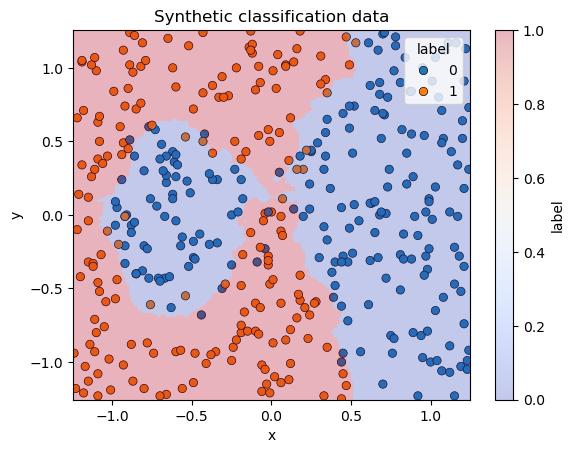

In [ ]:
sns.scatterplot(data=data,x='x', y='y' ,hue='label',edgecolor='black')
plt.title('Synthetic classification data')

## The decision boundary
x_min,x_max=data['x'].min(),data['x'].max()
y_min,y_max=data['y'].min(),data['y'].max()

xv,yv=np.meshgrid(np.linspace(x_min,x_max,200),np.linspace(y_min,y_max,200))

grid_points=pd.DataFrame(np.c_[xv.ravel(),yv.ravel()],columns=['x','y'])

label_pred=search.predict(grid_points)
label_pred=label_pred.reshape(xv.shape)

plt.pcolormesh(xv, yv, label_pred, antialiased=False, cmap='coolwarm',alpha=0.3)
plt.colorbar(label='label')


plt.show()

### 2. Fashion MNIST

Download the [*Fashion MNIST*](https://www.kaggle.com/datasets/zalando-research/fashionmnist) dataset from Kaggle.

To the training data, fit a pipeline model consisting of the following steps:

- `StandardScaler`

- `PCA`

- `SVC`

Use `GridSearchCV` to find good choices for

- the `n_components` parameter of `PCA`,

- the `C` and `kernel` parameters of `SVC`.

Evaluate your final model on the included test set and report your `accuracy_score`.

In [2]:
import kagglehub
import os

path = r"C:\Users\ekene\.cache\kagglehub\datasets\zalando-research\fashionmnist\versions\4"

# Check if the path exists
if not os.path.exists(path):
    # Download the latest version if the path does not exist
    path = kagglehub.dataset_download("zalando-research/fashionmnist")
    print("Dataset downloaded to:", path)
else:
    print("Path already exists:", path)



Path already exists: C:\Users\ekene\.cache\kagglehub\datasets\zalando-research\fashionmnist\versions\4


In [12]:
training_data = pd.read_csv(os.path.join(path ,"fashion-mnist_train.csv"))
testing_data = pd.read_csv(os.path.join(path ,"fashion-mnist_test.csv"))

X_train = training_data.drop('label', axis=1)
y_train = training_data['label']
X_test = testing_data.drop('label', axis=1)
y_test = testing_data['label']

X_train_reduced, _, y_train_reduced, _ = train_test_split(
    X_train, y_train, train_size=2000, stratify=y_train, random_state=42
)

print(y_train_reduced.value_counts())

label
8    200
2    200
0    200
5    200
7    200
6    200
9    200
4    200
1    200
3    200
Name: count, dtype: int64


In [16]:
features=X_train.shape[1]
params={'pca__n_components':np.arange(2,features,100),
        'svc__C':np.logspace(-3,2,5),
        'svc__kernel':['linear', 'poly', 'rbf', 'sigmoid']}

model=make_pipeline(StandardScaler(),PCA(),SVC())

search=GridSearchCV(model,param_grid=params,
                    cv=3,scoring='accuracy')

search.fit(X_train_reduced,y_train_reduced)

#evaluation
y_pred=search.predict(X_test)
accuracy=accuracy_score(y_test,y_pred)

print(f'Accuracy on the test set: {accuracy}')


Accuracy on the test set: 0.8408


In [14]:
search.best_params_

{'pca__n_components': 402, 'svc__C': 100.0, 'svc__kernel': 'rbf'}

### 3. A sports analytics application of logistic regression

In this course, our goal for regression modelling is typically *prediction*. However, it's also an important tool for *inferential* tasks.

This exercise develops an inferential application of logistic regression to a sports analytics problem. Specifically, we'll try to quantify evidence for the existence of a **home-field advantage** in the [CFL](https://www.cfl.ca) (Canadian Football League).

In the file `data/2024CFLScores.csv` is a record of all 95 CFL games played during the 2024 season.

In [3]:
import pandas as pd

df = pd.read_csv("data/2024CFLScores.csv")
df

,week,visitor,host,visitor_score,host_score
0,Preseason Week 1,WPG,SSK,12,25
1,Preseason Week 2,OTT,HAM,31,22
2,Preseason Week 2,SSK,EDM,28,27
3,Preseason Week 2,BC,CGY,6,30
4,Preseason Week 2,TOR,MTL,13,30
...,...,...,...,...,...
90,Eastern Semi-Final,OTT,TOR,38,58
91,Western Semi-Final,BC,SSK,19,28
92,Eastern Final,TOR,MTL,30,28
93,Western Final,SSK,WPG,22,38


Let $p_{ij}$ be the probability of the team $i$, the home team, winning a game against team $j$, the visiting team, is characterized by
$$
\log\left(\frac{p_{ij}}{1 - p_{ij}}\right) = \alpha + \beta_i - \beta_j.\tag{$*$}
$$

Here, $\alpha$ quantifies the home field advantage while $\beta_i$ and $\beta_j$ represent the strengths of teams $i$ and $j$, respectively. Thus, the home team is expected to win if its strentgh, plus the home field advantage, exceeds the strength of the visiting team.

Model ($*$) is a version the [*Bradley-Terry ranking model*](https://en.wikipedia.org/wiki/Bradley–Terry_model), modified to include home-field advantage.

Introduce an indicator variable $x_t$ for each team $t$ that takes the value $1$, $-1$, or $0$ for game $k$ according to whether team $t$ is the home team for game $k$, the visiting team for game $k$, or not involved in game $k$. 

**To do:** Generate the array `X` of shape `(95, 9)` as described above.

Encoded in this way, the right-hand side of ($*$) can be expressed as
$$
\alpha + \sum_t \beta_tx_t.
$$

**To do:** Generate a "home-team-wins" binary variable `y` of shape `(95,)`. Fit a logistic regression of `y` on `X` to estimate the parameters $\alpha$ and $\beta_t$. You may run into a problem involving tie games. I'll leave it to you to come up with a solution.

  - Rank the teams from best to worst in terms of decreasing value of $\beta_t$. Does this ranking match the league standings for 2024?

  - For which pairs of teams does the expected result of a game between them depend on where the game is being played? That is, which pairs of teams are sufficiently close in skill level that the estimated home field advantage makes up the gap, leading to the less skilled team being favored to win if the game is played in its city?

In [4]:
n_teams=len(df.host.unique())
n_games=len(df)
teams=df.host.unique()
dict_index=dict(zip(teams,np.arange(0,n_teams)))
## generate the X array
X= np.zeros((n_games,n_teams))
y=np.zeros((n_games))
for i,row in df.iterrows():
    host=row['host']
    visitor=row['visitor']

    X[i,dict_index[host]]=1
    
    X[i,dict_index[visitor]]=-1

for i,row in df.iterrows():
    if row['host_score']>row['visitor_score']:
        y[i]=1 # home team wins
    else:
        y[i]=0 # home team does not win




In [5]:
from sklearn.linear_model import LogisticRegression

log_model=LogisticRegression()
log_model.fit(X,y)

print(f'The intercept (alpha):{log_model.intercept_[0]:.2f}') # home field advantage

print(f'The coefficients are:{log_model.coef_[0]}') 



The intercept (alpha):0.43
The coefficients are:[ 0.27963356 -0.45714653 -0.49715539 -0.52164718  0.60223149  0.42861938
  0.12245328  0.14656488 -0.10355349]


In [6]:
## ranking the teams
log_model.feature_names_in_=teams

idx=log_model.coef_[0].argsort()[::-1]

print('The teams ranked from best to worst')
print('-------------------------------------')
print(log_model.feature_names_in_[idx])

The teams ranked from best to worst
-------------------------------------
['MTL' 'TOR' 'SSK' 'WPG' 'OTT' 'BC' 'HAM' 'EDM' 'CGY']


In [14]:
alpha=log_model.intercept_

team_pairs=[]
for team1,i in dict_index.items():
    for team2,j in dict_index.items():
        if team1 != team2:
            strength_diff=dict_team_strength[team1]< dict_team_strength[team2]
            home_advantage= alpha+dict_team_strength[team1] > dict_team_strength[team2]
            if strength_diff and home_advantage:
                team_pairs.append((team1,team2))

print("The team pairs that depend on home advantage")
print('----------------------------------------------')
team_pairs

The team pairs that depend on home advantage
----------------------------------------------


[('SSK', 'MTL'),
 ('SSK', 'TOR'),
 ('HAM', 'BC'),
 ('EDM', 'HAM'),
 ('EDM', 'BC'),
 ('CGY', 'HAM'),
 ('CGY', 'EDM'),
 ('CGY', 'BC'),
 ('TOR', 'MTL'),
 ('OTT', 'SSK'),
 ('OTT', 'TOR'),
 ('OTT', 'WPG'),
 ('WPG', 'SSK'),
 ('WPG', 'TOR'),
 ('BC', 'SSK'),
 ('BC', 'OTT'),
 ('BC', 'WPG')]

#### For your interest

I generated the data file by scraping this [page on](https://www.cfl.ca/schedule/2024/) the CFL web site using `bs4`. My code is below.

If you're shopping for project ideas, there are plenty of interesting sports analytics models you could have a look at...

In [ ]:
from bs4 import BeautifulSoup
import pandas as pd
import numpy as np

html = open("data/2024CFLSeasonScheduleAnsScores.html", "r").read()
soup = BeautifulSoup(html)

week = []
visitor = []
visitor_score = []
host = []
host_score = []

for schedule_week in soup.select(".schedule-week"):
    visitors = [
        span.text.strip()[:3].strip() for span in schedule_week.select("span.visitor")
    ]
    visitor.extend(visitors)
    visitor_scores = [
        int(span.text.strip()) for span in schedule_week.select("span.visitor-score")
    ]
    visitor_score.extend(visitor_scores)
    hosts = [
        span.text.strip()[:3].strip() for span in schedule_week.select("span.host")
    ]
    host.extend(hosts)
    host_scores = [
        int(span.text.strip()) for span in schedule_week.select("span.host-score")
    ]
    host_score.extend(host_scores)
    h2 = schedule_week.find("h2")
    assert h2 is not None
    weeks = [h2.text for _ in visitors]
    week.extend(weeks)

df = pd.DataFrame(
    {
        "week": week,
        "visitor": visitor,
        "host": host,
        "visitor_score": visitor_score,
        "host_score": host_score,
    }
)

df

,week,visitor,host,visitor_score,host_score
0,Preseason Week 1,WPG,SSK,12,25
1,Preseason Week 2,OTT,HAM,31,22
2,Preseason Week 2,SSK,EDM,28,27
3,Preseason Week 2,BC,CGY,6,30
4,Preseason Week 2,TOR,MTL,13,30
...,...,...,...,...,...
90,Eastern Semi-Final,OTT,TOR,38,58
91,Western Semi-Final,BC,SSK,19,28
92,Eastern Final,TOR,MTL,30,28
93,Western Final,SSK,WPG,22,38
